# Mixtures of probabilistic PCA

The class implementing MPPCA is very short as they are examples of linearly embedded mixture models.

It contains an \_\_init\_\_ constructor which defines the relevant linearly embedded mixture model as well as a function which helps initialise the linear map parameter from a set of means for the components.

The following code generates an example dataset, then fits a MPPCA to it.  We copy (roughly) an example from:

    Michael E. Tipping and Christopher M. Bishop,
    "Mixtures of Probabilistic Principal Component Analysers",
    Neural Computation 11(2), pp 443–482, MIT Press, 1999

In this example a generated helix dataset is used. A fit of a MPPCA model is compared to fits of GMMs with both diagonal and isotropic covariances matrices.

We finish by fitting a SMM to the same dataset for comparison.

## Imports

In [1]:
import numpy as np

from smm.lemm import MPPCA, GMM, GLEMM_Parameters_Untied, GLEMM_Parameters, GraphMM

%matplotlib inline
import matplotlib.pyplot as plt

## Generating the dataset

In [2]:
def gen_corkscrew(N, rnd):
    t = 4*np.pi*rnd.rand(N) - np.pi/2
    X = np.vstack([np.cos(t), np.sin(t), t]).T
    return X + 0.1 * rnd.standard_normal(size=X.shape)

X = gen_corkscrew(100, np.random.RandomState(123))
test_X = gen_corkscrew(1000, np.random.RandomState(1234))

## Fit a MPPCA

In [3]:
n_comp = 8
rnd = np.random.RandomState(12345)
MP = MPPCA(n_comp, 1, 3, rnd=rnd)

means = X[rnd.choice(range(X.shape[0]), n_comp, replace=False)]
V = MP.initial_V_from_means(means, 0.01)
TH = GLEMM_Parameters(V, MP.M, covar_type='spherical', covar=0.1)

for _ in range(250):
    TH = MP.step(TH, X)
    
print(f"The log-likelihood of the test set {MP.log_likelihood(TH, test_X):.3f}")
print(f"The log-likelihood of the training set {MP.log_likelihood(TH, X):.3f}")

The log-likelihood of the test set -3.191
The log-likelihood of the training set -1.550


We plot the results, each component has covariance matrix the sum of a common spherical part and a rank 1 matrix with the same covariance as that shown by the respective line segment

Common spherical part of the covariance matrix: 0.017, std: 0.131


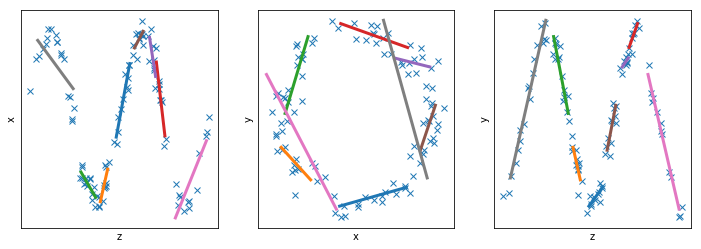

In [4]:
print(f"Common spherical part of the covariance matrix: {TH.covar:.3f}, std: {np.sqrt(TH.covar):.3f}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

labels = ['x', 'y', 'z']
for (i0, i1), ax in zip([(2,0), (0,1), (2,1)], axes):
    ax.scatter(X[:,i0], X[:,i1], lw=1, marker='x')
    ax.set_xlabel(labels[i0])
    ax.set_ylabel(labels[i1])
    ax.set_xticks(()), ax.set_yticks(())
    for i in range(MP.components):
        p = np.exp(TH.logp[i])
        if p > 0.0001:
            ax.plot((TH.V[2*i,i0], TH.V[2*i+1,i0]), (TH.V[2*i,i1], TH.V[2*i+1,i1]), lw=3)
plt.show()

## Fitting a Gaussian Mixture Model for comparison

In [5]:
n_comp = 8
rnd = np.random.RandomState(12345)
sphGMM = GMM(n_comp, 3, rnd=rnd)

means = X[rnd.choice(range(X.shape[0]), n_comp, replace=False)]

sphTH = GLEMM_Parameters_Untied(means, sphGMM.M, 
                                covar_type='spherical', 
                                covar=0.1+np.zeros(sphGMM.M))
diagTH = GLEMM_Parameters_Untied(means, sphGMM.M, 
                                 covar_type='diagonal', 
                                 covar=0.1+np.zeros((sphGMM.M, sphGMM.n)))
fullTH = GLEMM_Parameters_Untied(means, sphGMM.M, 
                                 covar_type='full', 
                                 covar=0.1 * np.ones((sphGMM.M,1,1)) * \
                                     np.eye(sphGMM.n))

for TH in [sphTH, diagTH, fullTH]:
    print(f"Results for GMM with *{TH.covar_type}* covariance matrix")
    for _ in range(250):
        TH = sphGMM.step(TH, X)

    print(f"The log-likelihood of the test set {sphGMM.log_likelihood(TH, test_X):.3f}")
    print(f"The log-likelihood of the training set {sphGMM.log_likelihood(TH, X):.3f}\n")

Results for GMM with *spherical* covariance matrix
The log-likelihood of the test set -3.809
The log-likelihood of the training set -2.898

Results for GMM with *diagonal* covariance matrix
The log-likelihood of the test set -3.638
The log-likelihood of the training set -2.740

Results for GMM with *full* covariance matrix
The log-likelihood of the test set -5.346
The log-likelihood of the training set -3.588



## Fitting a Simplicial Mixture Model for comparison

NB. Training is a lot slower

In [6]:
m, n = 8, 3

rnd = np.random.RandomState(123456)
L = GraphMM(m, n, rnd=rnd)

V = X[rnd.choice(range(X.shape[0]), m, replace=False)]
simpTH = GLEMM_Parameters(V, L.M, covar_type='spherical', covar=0.1)

for _ in range(250):
    simpTH = L.step(simpTH, X)
    
print(f"The log-likelihood of the test set {L.log_likelihood(simpTH, test_X):.3f}")
print(f"The log-likelihood of the training set {L.log_likelihood(simpTH, X):.3f}")

The log-likelihood of the test set -2.339
The log-likelihood of the training set -1.565


Observe that the log-likelihood of the test set is much improved over the MPPCA model, which in turn was much improved over the Gaussian mixture models.  We have not performed a full analysis over varying numbers of components and vertices, but this is a compelling demonstration of the various techniques.

To visualise the fitted SMM see the below plot.

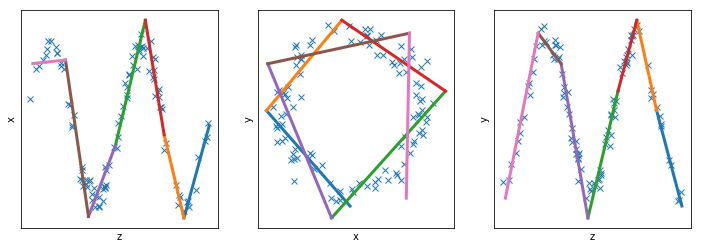

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

labels = ['x', 'y', 'z']
V = simpTH.V
for (i0, i1), ax in zip([(2,0), (0,1), (2,1)], axes):
    ax.scatter(X[:,i0], X[:,i1], lw=1, marker='x')
    ax.set_xlabel(labels[i0])
    ax.set_ylabel(labels[i1])
    ax.set_xticks(()), ax.set_yticks(())
    for i, lp in enumerate(simpTH.logp):
        s, t = L.rvs[i].S
        if np.exp(lp) > 0.0001:
            ax.plot((V[s,i0], V[t,i0]), (V[s,i1], V[t,i1]), lw=3)
plt.show()